# Version 1 of Tables (Final Final Final Version) - 10/25/2020#

major updates include

* cleaned sample after cross-matching with JM's siena galaxy atlas
  - I matched the VF catalog to SGA using a match radius of 10 arcsec
  - 1902 sources did not match
    - sources are listed here https://docs.google.com/spreadsheets/d/1l9Ay1NSc7ovFglQCZ3PphaHmXep3LFMcdxCOwrXFHgQ/edit?usp=sharing
  - we reviewed each source by eye
  - then went back to by_eye classifications to update the codes on any galaxies that should be
    - deleted
    - recentered
    - merged with another galaxy (e.g. alfalfa source with offset coordinates)
    
  - need to trace back to galnumber in the by-eye spreadsheet
  
* addition of any sources in Steer catalog with vr < 500 but redshift independent distance > vr/H0
  - these will need to have NSA, HL and A100 matches as well :(
  - this will require some more thought...
  
  
* remove repeat NED names - this is just a problem with the NED names, not with the actual galaxies

In [ ]:
from astropy.io import fits, ascii
from matplotlib import pyplot as plt
from astropy.table import Table
import os
import numpy as np
%matplotlib inline


## 1.  Comparison with Siena Galaxy Atlas ##

**Description:**
we have finished reviewing all the galaxies that didn't match to JM's Siena Galaxy Atlas.  The list of matching galaxies is at:
https://docs.google.com/spreadsheets/d/1l9Ay1NSc7ovFglQCZ3PphaHmXep3LFMcdxCOwrXFHgQ/edit?usp=sharing

**Remedy:**
We will update the byeye classification spreadsheet.  The 
spreadsheet is at

https://docs.google.com/spreadsheets/d/1GtvYTBU3tAXI7ngklFWms3WpnGhbzpp3Nn-_VO7sioc/edit?usp=sharing

Download as a xlsx file.  Will get saved in ~/Downloads/

**Action Items**
* need to carry original galnumber from the kitchen_sink through to the vf_clean catalog.
* added function add_byeye_galid in clean_kitchen_sink.py to add this column to the cleaned catalog
* rerun clean_kitchen_sink.py
  * creates vf_clean_sample.fits (9217 lines)
* rerun get_NEDname.py
  * creates vf_clean_sample_wNEDname.fits (9217 lines)
  * previous version had 9214 :(
* remove sources that have [KHL2017]S in name - updated byeye spreadsheet accordingly
* download updated bye eye spreadsheet and save in research/Virgo/google-tables
  * first download latest version of virgo_check_by_eye from google spreadsheet, save as excel file
  * move to ~/research/Virgo/google-tables
   ```
   mv ~/Downloads/virgo_check_sample_by_eye.xlsx virgo_check_sample_by_eye_v1.finished.xlsx
   ```
  * run this program 
   ```
   python ~/github/Virgo/programs/collate_check_by_eye_results.py
   ```
  * or from within ipython -pylab
```
%run ~/github/Virgo/programs/collate_check_by_eye_results.py
```
* download csv version of updated VF-notin-SGA 

```
mv ~/Downloads/VF-notin-SGA-10arcsecmatch-bestmatch-symmetric\ -\ VF-notin-SGA.csv VF-notin-SGA-10arcsecmatch-bestmatch-symmetric.csv

```
* rerun clean_kitchen_sink.py
  * will output v1 of files
    * output_catalog = 'vf_clean_sample_v1.fits'
    * output_clean = 'clean_sample_v1.fits' # I'm not sure why I have two output files, just a holdover I think
    * ipac_table = 'clean_sample_v1.txt'

**NOTES**
I updated the original classification spreadsheet based on our assessments of the galaxies that don't match JM's catalog.  I need to preserve the kitchen sink catalog b/c this is our last link to the original classification spreadsheet and cutouts.  I am uploading it to the visual classification folder.  This notebook describes how I related VFID in v0 catalogs to the line number in smart_kitchen_sink_v2.fits.  

We also noted galaxies that have a radius that was too big or too small.  I am going to incorporate this information into the write_subtables, where we merge different radial size estimates.  Added this to the function get_radius. 

We updated centers for some galaxies, but JM said not to both b/c his code will figure this out.
  
  
  


## 1a. Update byeye classifications ##

* get galnumber for VFID for galaxies in the https://docs.google.com/spreadsheets/d/1l9Ay1NSc7ovFglQCZ3PphaHmXep3LFMcdxCOwrXFHgQ/edit?usp=sharing
* update the by-eye classifications https://docs.google.com/spreadsheets/d/1GtvYTBU3tAXI7ngklFWms3WpnGhbzpp3Nn-_VO7sioc/edit?usp=sharing
  * updating sheet on 2020-10-25
  
* having trouble reading the csv file into python - the headers are getting cutout.  This was b/c I had multiple columns with the same name.  Fixed this and now it loads fine.

  
### more Details on how I updated the byeye spreadsheet

Basically, this involved linking the VFID with the galaxy number in the original spreadsheet

* the number in the original spreadsheet is the line number in smart_kitchen_sink.v2.fits
* however, when I reran clean_kitchen_sink in Oct 2020, I ended up with 3 extra galaxies (no idea why), and so the VFIDs were different.
* figured things out eventually, but I ended up searching for objects by name.

### This is what worked in Oct 2020

In [ ]:
badgals = Table.read('/home/rfinn/research/Virgo/google-tables/VF-notin-SGA-10arcsecmatch-bestmatch-symmetric.csv',format='ascii')
# keep galaxies that we need to get rid of 
badflag = badgals['keep?'] == 0
badgals = badgals[badflag]
sink = Table.read('/home/rfinn/research/Virgo/supersample/smart_kitchen_sink_v2.fits')

In [ ]:
# match galaxies according to their name
sinkindex = np.arange(len(sink))
match_field = ['objname','NSAID','NSAIDV0']
sink_field = ['objname','NSAID','NSAID_2']
outfile = open('/home/rfinn/research/Virgo/google-tables/byeye-crossmatch-ids.csv','w')
for i in range(len(badgals)):
    matchflag=False
    for j in range(len(match_field)):
        gname = badgals[match_field[j]][i]
        if (gname != 'N/A'):# & (gname != 0):
            gflag = sink[sink_field[j]] == gname
            if sum(gflag) == 1:
                #print(badgals['VFID'][i],sinkindex[gflag][0])
                s = '%s, %i \n'%(badgals['VFID'][i],sinkindex[gflag][0])
                outfile.write(s)
                matchflag=True
                break
            elif sum(gflag) == 2:
                print(badgals['VFID'][i],sinkindex[gflag])
                s = '%s, %i, %i \n'%(badgals['VFID'][i],sinkindex[gflag][0],sinkindex[gflag][0])
                outfile.write(s)
                matchflag=True
            elif sum(gflag) > 1:
                pass
        
    if not(matchflag):
        #print('HELP!!! no match for',badgals['VFID'][i],gname)
        print(badgals['VFID'][i],-999)
        outfile.write('%s, %i \n'%(badgals['VFID'][i],-999))
outfile.close()

## 2.  BV has found additional galaxies to add from Steer and EVCC ##

* galaxies in Steer with vr< 500 but redshift-independent distances that are consistent with our cut
* a few from EVCC that are not included (from Kim paper)
* these need to be added to the catalog
* these additional galaxies include all but one of GL's 245 CO galaxies
  * IC 3094 is not included.  It's redshift independent distance corresponds to a vr = 3478 (H0=74), so this shouldn't be in the sample.
    - it's in the steer catalog
    - vcomic = -237 km/s
  * followed up with Gianluca, and this should NOT be included, so we are ok
* file is in 
```
research/Virgo/ancil-tables/Steer_EVCC_toadd_fromBV_2020Oct27.fits  
```

### possible options for implementing

* using topcat, match steer catalog to 
  * HL, agc,NSAv1,NSAv0, a100-sdss-wise to produce a second table with columns that match the clean_kitchen_sink
  * stilts - command line version of topcat - could be useful for repeating analysis multiple times

* make new version of mksupersample, but use steer catalog as the input instead of HL?

* download vr < 500 version of HL catalog, match to catalog of new galaxies (steer + EVCC), then use this as HL catalog in a new version of mksupersample that only matches this catalog to agc, NSAv1, NSAv0
  - this catalog could be added in clean_kitchen_sink so that indices of previous sources don't change (for example, when I clean/merge the new a100 sources).  Although maybe this is not the way to go because the "new" A100 sources that we find in clean_kitchen_sink might match to one of new sources?
  
* these galaxies need to be added to the clean_kitchen_sink file
  * GL's catalog has HL information
  * write a separate program to match to HL, NSAv0, and NSAv1
  * a100 matching will happen in clean_kitchen_sink
  
  
### Approach

* download new HL catalog, but remove low vr cut

```
 Hyperleda query:  http://leda.univ-lyon1.fr/fullsql.html

        parameters described here: http://leda.univ-lyon1.fr/leda/meandata.html

        SQL QUERY:
        
        select
        objname,objtype,de2000,al2000,v,e_v,vopt,e_vopt,vrad,e_vrad,bt,e_bt,type,bar,ring,multiple,compactness,t,e_t,logd25,e_logd25,logr25,e_logr25,pa,incl,logdc,btc,itc,ubtc,bvtc,m21c,hic,mabs,agnclass,kt,e_kt,it,e_it,ut,vt,mfir,e_ut,e_vt, modz, e_modz, mod0, e_mod0,vmaxg, e_vmaxg, vmaxs,e_vmaxs,vdis,e_vdis
        
        where

        de2000 > -35 and de2000 < 75 and  al2000 < 280./360.*24.  and al2000 > 100./360.*24. and v < 3300 and objtype='G'

        - output as csv, separator is other, ,

        delete header lines at beginning and end

        2020-10-28: downloaded again but removed the vr > 500 km/s cut.
        we are adding galaxies with redshift-independent distances > 500/H0, and 
        they should be in this updated catalog

          - will add this functionality in a separate function

```

## Matched BV's catalog with HL in topcat.  

* Four galaxies don't match

|RA | DEC | VH | NOTES |
|---|----|-----|-------|
| 176.1337 | 6.7041 | 1455.2 | NSA 067042, has a redshift of ~5800 km/ from several sources.  NED says no z-independent distance. AGC 215601 comes up in HL with vr=5700. |
|187.8029 | 13.1243 | 1900 | in HL (PGC041416), and they list vr=1900, but they use sdss vr as primary (242316) |
| 190.0388 | 6.8837 | 1007 | VCC 1821, PGC 042420.  HL has vr=7300, but it also lists 2 redshifts at 1007km/s |
| 195.9078 | 7.904 | 2968 | CGCG 043-122, PGC 045112 and NSA 077423; again HL has vr=13700; sdss redshift is convincing |


* Saving file as fits basic, Steer_EVCC_toadd_fromBV_2020Oct27_with_HL.fits, in ~/research/Virgo/ancil-tables

* read in table and remove the columns from Benedetta's table so just HL is there.  but first use BV ra, dec and vr if galaxy doesn't match to HL




In [ ]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/clean_kitchen_sink.py


In [ ]:
infile = '/home/rfinn/research/Virgo/ancil-tables/Steer_EVCC_toadd_fromBV_2020Oct27_with_HL.fits'
tab = Table.read(infile)

In [ ]:
for i in range(len(tab)):
    if tab['objname'][i] == '                            ': # no match to HL
        ra = tab['RA'][i]/15. # convert ra from deg to hr
        dec = tab['DEC'][i]
        tab['al2000'][i] = ra
        tab['de2000'][i] = dec
        tab['v'][i] = tab['VH'][i]
        print('fixing values for gal with no HL match')
        

In [ ]:
# this only works if you save the sorted table in topcat
for i in range(4):
    if i == 0:
        tab['objname'][i]='AGC215601'
    elif i == 1:
        tab['objname'][i]='PGC041416'
    elif i == 2:
        tab['objname'][i]='PGC042420'
    elif i == 3:
        tab['objname'][i]='PGC045112'

In [ ]:
# remove column
col_names = tab.colnames[0:10]
print(col_names)
tab.remove_columns(col_names)
# save file as a short HL table
outfile = '/home/rfinn/research/Virgo/ancil-tables/Steer_EVCC_toadd_HL_cols.fits'
tab.write(outfile,format='fits',overwrite=True)

### updated mksupersample

it now has --version and --evcc flags

* set evcc to read in the file we just wrote, and create an independent smart_kitchen_sink_v2_v1_evcc.fits
* version is v1 by default, until we move on to v2 tables



In [ ]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/mksupersample.py --evcc

In [ ]:
s=sample()
s.get_smart()

### woo hoo!!!

This worked!  

wrote file smart_kitchen_sink_v2_v1_evcc.fits


# 3. Moving toward final table -  Clean kitchen sink

* don't need to clean any galaxies, but some extra columns get added in this program, so this is the best place to do the vertical stack of our main table with the table of extra galaxies from evcc and steer

* I added command-line arguments --evcc and --version

* produces vf_clean_sample_v1.fits



In [201]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/clean_kitchen_sink.py --evcc

number of A100-only before cleaning =  44
number of duplicates =  1
AGC-only galaxies with duplicate entries
AGC 
----
5844
	double entry for AGC  5020
	double entry for AGC  5078
	double entry for AGC  5522
	double entry for AGC  5844
	double entry for AGC  5844
	double entry for AGC  5898
	double entry for AGC  6300
	double entry for AGC  7170
	double entry for AGC  7547
	double entry for AGC  9991
	double entry for AGC  202240
	double entry for AGC  211006
	double entry for AGC  213175
	double entry for AGC  213312
	double entry for AGC  214730
	double entry for AGC  220432
	double entry for AGC  220616
	double entry for AGC  220863
	double entry for AGC  220865
	double entry for AGC  222214
	double entry for AGC  222671
	double entry for AGC  224236
	double entry for AGC  226606
	double entry for AGC  229200
	double entry for AGC  232162
	double entry for AGC  233575
	double entry for AGC  238771
	double entry for AGC  240021
	double entry for AGC  241947
	double entry for AGC  722

## Success!  But... a100 indices will be wrong in clean_new_a100

### Updated code to review a100 galaxies #

* previously, I had run check_new_a100 to review the a100 galaxies that were added.  
* the function clean_new_a100 got rid of the duplicates, or merged them with the correct parent

```
        child = np.array([7423, 9207, 9209, 8952],'i')
        parent = np.array([9206, 6575, 6638, 9213],'i')
        for i in range(len(child)):
            print('merging {} with {}'.format(child[i],parent[i]))
            self.merge_sources(parent[i],child[i],cat=self.clean_a100,HL=False,NSA=False,AGC=False,A100=True)
            self.clean_a100['A100flag'][parent[i]] = True
```

* the updated catalog has different order, so now I have to redo the a100 match

* moving forward, I should match by some name rather than array index, in case we update the catalog again.


### Solution

* The solution is to uncomment **def check_new_a100** and comment out the rest of **runall**
* review the galaxies
* if they are part of a galaxy that is already in the catalog, then merge the sources.  if we have a new version, then the index numbers will need to be updated in the function **clean_new_a100**

### NOTE
* I also fixed an error in the allgals function - the y coordinate in the jpeg image was set to the y value that comes from the conversion from RA and DEC, but it needs to be y_image_size - y for the jpeg image.  I had fixed this in mksupersample.py, but didn't fix this in clean_kitchen_sink.py


In [ ]:
# got an error because indices in clean_new_a100 pointed to old indices


In [247]:
# running again with check_new_a100 uncommented in runall
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/clean_kitchen_sink.py --evcc
plt.show()

number of A100-only before cleaning =  47
number of duplicates =  1
AGC-only galaxies with duplicate entries
AGC 
----
5844
	double entry for AGC  8276
	double entry for AGC  7227
	double entry for AGC  223771
	double entry for AGC  5020
	double entry for AGC  5078
	double entry for AGC  5522
	double entry for AGC  5844
	double entry for AGC  5844
	double entry for AGC  5898
	double entry for AGC  6300
	double entry for AGC  7170
	double entry for AGC  7547
	double entry for AGC  9991
	double entry for AGC  202240
	double entry for AGC  211006
	double entry for AGC  213175
	double entry for AGC  213312
	double entry for AGC  214730
	double entry for AGC  220432
	double entry for AGC  220616
	double entry for AGC  220863
	double entry for AGC  220865
	double entry for AGC  222214
	double entry for AGC  222671
	double entry for AGC  224236
	double entry for AGC  226606
	double entry for AGC  229200
	double entry for AGC  232162
	double entry for AGC  233575
	double entry for AGC  238771


### Then update clean_new_a100 sources and update indices of AGC-only sources that need to be merged

* can uncomment check_new_a100 when done
* you get the indices from the cutout images (and the printout of which images are in FOV, if text overlaps or is hard to read)
* uncomment the rest of runall, and comment out check_new_a100
* Then run again


In [248]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/clean_kitchen_sink.py --evcc


number of A100-only before cleaning =  47
number of duplicates =  1
AGC-only galaxies with duplicate entries
AGC 
----
5844
	double entry for AGC  8276
	double entry for AGC  7227
	double entry for AGC  223771
	double entry for AGC  5020
	double entry for AGC  5078
	double entry for AGC  5522
	double entry for AGC  5844
	double entry for AGC  5844
	double entry for AGC  5898
	double entry for AGC  6300
	double entry for AGC  7170
	double entry for AGC  7547
	double entry for AGC  9991
	double entry for AGC  202240
	double entry for AGC  211006
	double entry for AGC  213175
	double entry for AGC  213312
	double entry for AGC  214730
	double entry for AGC  220432
	double entry for AGC  220616
	double entry for AGC  220863
	double entry for AGC  220865
	double entry for AGC  222214
	double entry for AGC  222671
	double entry for AGC  224236
	double entry for AGC  226606
	double entry for AGC  229200
	double entry for AGC  232162
	double entry for AGC  233575
	double entry for AGC  238771


# 4. Match to external catalogs

* clean_kitchen_sink makes an ipac table in Virgo/supersample called clean_sample_v1.txt
* this has 9154 sources

## Match catalog to z0MGS
* upload this to IRSA https://irsa.ipac.caltech.edu/data/WISE/z0MGS/overview.html
  * catalog search Tool
  * z0MGS DR1 (not 7.5 arcsec Simple Index)
  * gets here https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd
  * multi-object search
    * 30 arcsec
    * 1-to-1 match
    * run query
    * 9156 sources found (that's how many are in input table)
  * shows results, then click save icon
    * save as ipac table.  
    ```
    cd ~/research/Virgo/tables
    mv ~/Downloads/irsa_catalog_search_results_tbl.tbl vf_v1_z0mgs_30arcsec_102820.tbl
    ```
    * NOTE: we used 30 arcsec last time...
  * update filename in write_subtables, get_z0MGS_flag()
  
## Match to AllWISE
* upload table to IRSA, AllWISE Source Catalog
    * multi-object search
    * 30 arcsec
    * 1-to-1 match
    * run query
    * 9156 sources found (that's how many are in input table)
  * shows results, then click save icon
    * save as ipac table.  
    ```
    cd ~/research/Virgo/tables
    mv ~/Downloads/irsa_catalog_search_results_tbl.tbl vf_v1_allwise_30arcsec_102820.tbl
    ```
    
## Match to WISE All-sky 
* upload table to IRSA, AllWISE Source Catalog
    * multi-object search
    * 30 arcsec
    * 1-to-1 match
    * run query
    * 9156 sources found (that's how many are in input table)
  * shows results, then click save icon
    * save as ipac table.  
    ```
    cd ~/research/Virgo/tables
    mv ~/Downloads/irsa_catalog_search_results_tbl.tbl vf_v1_allwise_30arcsec_102820.tbl
    ```

# 5. Updating NED names

Ended up running the NED query again - good to do for new version

* file with NED names ned_names_v1_evcc.fits
  * the program should read this in the next time it is run

In [249]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/get_NEDname.py --evcc

found file ned_names_v1_evcc.fits
Using this instead of querying NED
[False False False ... False False False]


## 2b. Check to see if all Gianluca's CO sources are in the catalog

* Benedetta is cross-matching the vf_clean_sample_wNEDnames_v1_evcc.fits with GL's catalog.

* from email on 9/22/2020

```
Hi Rose,

thanks for having checked!

here are the redshifts from NED : vr>500 km/s means z >~ 0.00166, so none of them are at vr>500 km/s, which is good! The drawback is that now we miss galaxies in the Virgo cluster. I personally find it a bit weird since we are specifically building a catalog of galaxies around Virgo, but if we explain our selection criteria maybe it should be convincing.

cheers

gianluca

1  | |IC 3094                   | -0.000530|   
2  | |IC 3476                   | -0.000564|   
3  | |MESSIER 059               |  0.001558|   
4  | |MESSIER 086               | -0.000747|   
5  | |MESSIER 089               |  0.001134|   
6  | |MESSIER 090               | -0.000784|   
7  | |MESSIER 091               |  0.001621|   
8  | |MESSIER 098               | -0.000474|   
9  | |NGC 4178                  |  0.001248|   
10 | |NGC 4208                  | -0.000270|   
11 | |NGC 4216                  |  0.000437|   
12 | |NGC 4222                  |  0.000767|   
13 | |NGC 4294                  |  0.001184|   
14 | |NGC 4312                  |  0.000510|   
15 | |NGC 4396                  | -0.000427|   
16 | |NGC 4402                  |  0.000774|   
17 | |NGC 4407                  |  0.000340|   
18 | |NGC 4419                  | -0.000871|   
19 | |NGC 4424                  |  0.001458|   
20 | |NGC 4438                  |  0.000237|   
21 | |NGC 4445                  |  0.001181|   
22 | |NGC 4550                  |  0.001531|   
23 | |NGC 4634                  |  0.000991|    

```

Benedetta checked this and we are ok except for IC 3094, which is not actually in Gianluca's catalog.

### DONE

## 3. Galaxies that point to the same NED name ##

In [214]:
t = 'a b c'
s=t.replace(' ','')
print(s)

abc


## 5. Make new version of sub-tables ##


### Need to add code for Galaxies with updated radius measurements from by-eye

* update input filename in write_subtables - masterfile (didn't update this the first time through)
* I updated the function **get_radius** to do this!

### Still to do

* check for repeats of NED name (or any other id)
* update unwise - ask Dustin to match to the new version v1
* use Gianluca's updated CO file with 245 galaxies (I'm currrently using an older one with 217)



In [ ]:
# match to unwise
# send catalog to Dustin Lang

CO sources with no match in mastertable:
        NEDname                source_name      
------------------------ -----------------------
 2MASX J13522492+3933269               ASK322610
 2MASX J15053582+5905371               ASK110438
                NGC 4214                 NGC4214
                NGC 4244                 NGC4244
SDSS J120958.40+462726.6 SDSSJ120958.40+462726.6
               SHOC 206b                SHOC206b
number of galaxies with CO matches =  239
number of duplicates =  2
CO sources that are matched to multiple galaxies in the mastertable:
 NEDname 
---------
      N/A
UGC 10770
number of duplicates =  10
Halpha sources that are listed multiple times in the halpha file:
  VFID  
--------
VFID2060
VFID2076
VFID2080
VFID2089
VFID2095
VFID2136
VFID2141
VFID2145
VFID2154
VFID2157
number of lines in ha file after deleting rows =  100
number of columns after removing cols =  224
calculating snr


/home/rfinn/github/Virgo/programs/write_subtables.py:733: RuntimeWarning: invalid value encountered in true_divide
  self.haflag = ((self.hatable['HF_R24']/self.hatable['HF_R24_ERR']) > 1.)
/home/rfinn/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


setting HAflag
writing hafile
finished writing hafile
number of galaxies with D25 measurement = 5732 (0.84%)
number of galaxies using NSA V1 Petro TH90 = 476 (0.07%)
number of galaxies using NSA V1 Petro TH90 = 65 (0.01%)
number of galaxies using A100 sdss Petro TH90 = 262 (0.04%)
number of galaxies with no size measurement = 264 (0.04%)
adjusting radius for  --  galaxies based on legacy images
number of galaxies with updated values of radius =  146
CALCULATING SFRS


/home/rfinn/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


1.1938664705522868


/home/rfinn/github/Virgo/programs/write_subtables.py:417: RuntimeWarning: divide by zero encountered in log10
  self.logMHI = np.log10(2.36e5*self.cat['HIflux'])+2*np.log10(self.cat['Dist']) #Dist^2
/home/rfinn/github/Virgo/programs/write_subtables.py:443: RuntimeWarning: divide by zero encountered in log10
  logD25kpc=np.log10(D25obskpc.value) + 0.35*np.log10(self.cat['expAB_r'])
/home/rfinn/github/Virgo/programs/write_subtables.py:463: RuntimeWarning: invalid value encountered in subtract
  self.HIdef_bos = logh2MHIref - self.logMHI


number of lines in z0MGS cat =  9153
length of keepnorth_flag =  9153


Number in sample =  6799
Number with CO data =  239
Number with A100 data = 2336 (0.344)
Number with z0MGS matches = 2370 (0.349)
Number with steer17 matches = 1884 (0.277)
CO SOURCES
	Number of CO sources in z0MGS = 234 (0.98)
	Number of CO sources in Steer = 178 (0.74)
	Number of CO sources in z0MGS+Steer = 177 (0.74)
FYI: no unwise flag


FileNotFoundError: [Errno 2] No such file or directory: '/home/rfinn/research/Virgo/tables-north/v1/vf_north_v0_main_unwise.fits'

<Figure size 432x288 with 0 Axes>

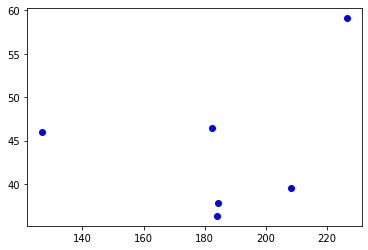

In [257]:
# write sub tables

# commenting out get_unwise, because I'll have to match to new table
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/write_subtables.py --north 
c.runall()

In [ ]:
t = Table.read(homedir+'/research/Virgo/google-tables/VF-notin-SGA-10arcsecmatch-bestmatch-symmetric.csv',format='ascii')

# Creating other tables

* first round through subtables will create a table with
  - RA, DEC,

* z0MGS

* unWISE

* cross-match to Tempel catalog 
  * BV has program to cross match mastertable with Tempel catalog
  * create a line-matched table with group 1 and properties of the parent halo for each galaxy that matches to Tempel
  * it will also include a field/filament/cluster identifier
  
* Gianluca's environment table
  * where is the best place to put this, does it need to run again?
  
* legacy photometry

# Final step - create main table with flags for all data products



# Old stuff - keeping in case it's useful

In [ ]:
d = fits.getdata('/home/rfinn/research/Virgo/supersample/vf_clean_sample.fits')

In [ ]:
vfdict = dict((a,b) for a,b in zip(d['VFID'],d['galnumber']))

In [ ]:
dd = Table.read('/home/rfinn/research/Virgo/tables-north/v1/vfid-2delete.txt',format='ascii',data_start=0)

In [ ]:
# old stuff that might be useful, but didn't work for making version 1
outfile = open('/home/rfinn/research/Virgo/tables-north/v1/byeyeid-2delete.txt','w')
for d in dd:
    print(d[0],vfdict[d[0]])
    s = str(str(vfdict[d[0]])+'\n')
    outfile.write(s)
outfile.close()